# Environment setup and imports

In [1]:
# Install packages
!pip install requests tensorFlow==2.15.0 pandas numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [18]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy import vstack
from numpy.random import randint
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from matplotlib import pyplot
import os
from os import listdir
import requests
import time
import gc

# Mount Drive

In [3]:
# CHANGE THIS MACRO WHETHER YOU DONT WANT TO SAVE THE MODEL IN YOUR GOOGLE DRIVE.
COLAB = True

In [5]:
from google.colab import drive
if COLAB:
  drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Utils

In [38]:
# load source and target images
def load_images(src_path, tar_path, size=(256, 256)):
  src_list, tar_list = list(), list()
  # Iterate over source images
  for filename in listdir(src_path):
    # load and resize the source image
    pixels = load_img(src_path + filename, target_size=size)
    # convert to numpy array
    art_img = img_to_array(pixels)
    src_list.append(art_img)
    # get the sketch image
    pixels = load_img(tar_path + filename, target_size=size)
    # convert to numpy array
    sketch_img = img_to_array(pixels)
    tar_list.append(sketch_img)

  return asarray(src_list), asarray(tar_list)

# normalize image to [-1, 1] interval
def normalize_imgs(images):
  # convert from integers to floats
  images = images.astype('float32')
  # scale from [0,255] to [-1,1]
  images = (images - 127.5) / 127.5
  return images

# select a batch of random samples, returns images and target
def generate_real_samples(trainA, trainB, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

# generate a batch of images with the generator model, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
  clear_session()
  X = g_model.predict(samples)
  # create 'fake' class labels (0)
  y = zeros((len(X), patch_shape, patch_shape, 1))
  return X, y

# function to eval the performance of the model in a given step
def summarize_performance(step, g_model, trainA, trainB, n_samples=3):
  # select a sample of input images
  [X_realA, X_realB], _ = generate_real_samples(trainA, trainB, n_samples, 1)
  # generate a batch of fake samples
  X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
  # scale all pixels from [-1,1] to [0,1]
  X_realA = (X_realA + 1) / 2.0
  X_realB = (X_realB + 1) / 2.0
  X_fakeB = (X_fakeB + 1) / 2.0
  # plot real source images
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X_realA[i])
  # plot generated target image
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(X_fakeB[i])
  # plot real target image
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
    pyplot.axis('off')
    pyplot.imshow(X_realB[i])
  # save plot to file
  filename1 = '/content/gdrive/MyDrive/splash-drawer-files/plot_%06d.png' % (step+1)
  pyplot.savefig(filename1)
  pyplot.close()
  pyplot.clf()
  # save the generator model
  filename2 = '/content/gdrive/MyDrive/splash-drawer-files/model_%06d.h5' % (step+1)
  g_model.save(filename2)
  # delete variables
  del X_realA
  del X_realB
  del X_fakeB
  print('>Saved: %s and %s' % (filename1, filename2))

# function to easy generate a splash art from a sketch, given a trained model
def generate_splash_art(g_model, sketches, original_images, test_idx, n_samples=3):
  os.makedirs("outputs", exist_ok=True)
  # select a sample of input images
  [X_realA, X_realB], _ = generate_real_samples(sketches, original_images, n_samples, 1)
  # generate a batch of fake samples
  X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
  # scale all pixels from [-1,1] to [0,1]
  X_realA = (X_realA + 1) / 2.0
  X_realB = (X_realB + 1) / 2.0
  X_fakeB = (X_fakeB + 1) / 2.0
  # save generated images
  for i in range(n_samples):
    pyplot.axis('off')
    pyplot.imshow(X_fakeB[i])
    fname = 'outputs/output_' + str(test_idx + i) + '.png'
    pyplot.savefig(fname)
    pyplot.close()
    pyplot.clf()
  # plot real source images
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X_realA[i])
  # plot generated target image
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(X_fakeB[i])
  # plot real target image
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
    pyplot.axis('off')
    pyplot.imshow(X_realB[i])
  # save plot to file
  filename1 = '/content/outputs/plot_%d.png' % (test_idx)
  pyplot.savefig(filename1)
  pyplot.close()
  pyplot.clf()
  # delete variables
  del X_realA
  del X_realB
  del X_fakeB
  print('>Saved: %s and generated images' % (filename1))

# Download and preprocess data

In [21]:
# import datasets from github
urls = ["https://github.com/JoaoP-Silva/splash-drawer/raw/main/data/splash_arts/images.zip",
        "https://github.com/JoaoP-Silva/splash-drawer/raw/main/data/sketches/sketches.zip",
        "https://github.com/JoaoP-Silva/splash-drawer/raw/main/data/test/splash_arts/images.zip",
        "https://github.com/JoaoP-Silva/splash-drawer/raw/main/data/test/sketches/sketches.zip"]

local_filenames = ["data/images.zip", "data/sketches.zip", 'data/test/images.zip', 'data/test/sketches.zip']

# create data DIRs
os.makedirs("data/test", exist_ok=True)

# download datasets
for i, url in enumerate(urls):
  with requests.get(url, stream=True) as r:
      r.raise_for_status()
      with open(local_filenames[i], 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  time.sleep(1)

In [8]:
# unzip training files
!unzip data/images.zip -d data/splash_arts
!unzip data/sketches.zip -d data/sketches

Archive:  data/images.zip
  inflating: data/splash_arts/5daf7096b4939e017dbedd7e_WestStudio_LOL_Splash_04.jpg  
  inflating: data/splash_arts/5daf70f35cfc0dca662934de_WestStudio_LOL_Splash_05.jpg  
  inflating: data/splash_arts/5e2248283320f334f1a3cd74_WestStudio_LOL_Splash_08.jpg  
  inflating: data/splash_arts/5e2249036620d852955949fe_WestStudio_LOL_Splash_11.jpg  
  inflating: data/splash_arts/5e2249a0fce9952fc009f81a_WestStudio_LOL_Splash_13.jpg  
  inflating: data/splash_arts/5e224a2c8ce4aab108096a9b_WestStudio_LOL_Splash_16.jpg  
  inflating: data/splash_arts/5e2a3ca417894028d25e5d7c_WestStudio_LOL_Splash_14.jpg  
  inflating: data/splash_arts/60411c26dec94efd2de6bc18_WestStudio_LOL_Splash_19.jpg  
  inflating: data/splash_arts/60411d3529f6b12a5a0af3be_WestStudio_LOL_Splash_21.jpg  
  inflating: data/splash_arts/60411e20b5a6cc7805419c87_WestStudio_LOL_Splash_24.jpg  
  inflating: data/splash_arts/60411e567c9000a853bd139b_WestStudio_LOL_Splash_25.jpg  
  inflating: data/splash_art

In [22]:
# unzip test files
!unzip data/test/images.zip -d data/test/splash_arts
!unzip data/test/sketches.zip -d data/test/sketches

Archive:  data/test/images.zip
  inflating: data/test/splash_arts/garen_dreadknight.jpg  
  inflating: data/test/splash_arts/garen_god_king.jpg  
  inflating: data/test/splash_arts/garen_steel_legion.jpg  
Archive:  data/test/sketches.zip
  inflating: data/test/sketches/garen_dreadknight.jpg  
  inflating: data/test/sketches/garen_god_king.jpg  
  inflating: data/test/sketches/garen_steel_legion.jpg  


In [23]:
# remove zip files
!rm data/images.zip
!rm data/sketches.zip
!rm data/test/images.zip
!rm data/test/sketches.zip

In [46]:
# generate numpy arrays with training images
src_path = "data/sketches/"
tar_path = "data/splash_arts/"
src_images, tar_images = load_images(src_path, tar_path)
# print to assert that all 78 images were loaded, with 256x256 and 3 chanels
print(src_images.shape, tar_images.shape)

(78, 256, 256, 3) (78, 256, 256, 3)


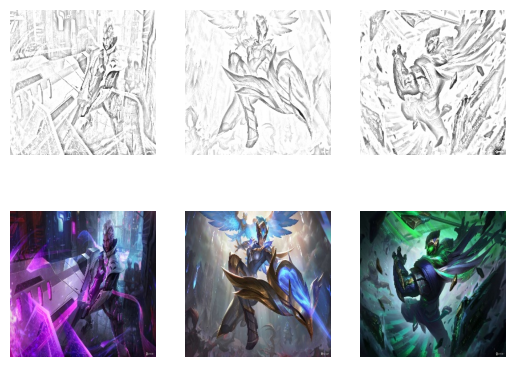

In [47]:
# plot few images to check if the data was loaded right
n_samples = 3
# plot splash arts
for i in range(n_samples):
 pyplot.subplot(2, n_samples, 1 + i)
 pyplot.axis('off')
 pyplot.imshow(src_images[i].astype('uint8'))
# plot sketches
for i in range(n_samples):
 pyplot.subplot(2, n_samples, 1 + n_samples + i)
 pyplot.axis('off')
 pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [48]:
# rescale images
src_images = normalize_imgs(src_images)
tar_images = normalize_imgs(tar_images)

# Defining Discriminator and Generator

In [12]:
# define the discriminator model
def define_discriminator(image_shape):
	# random weight initialization
	init = RandomNormal(stddev=0.02)
	# splash art input
	in_src_image = Input(shape=image_shape)
	# sketch image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
  # sigmoid to get probabillity whether the generator image is real or not
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=0.5)
	return model

In [13]:
# This cell defines the generator model, composed of the encoder/decoder blocks

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# random weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# In the U-net model, every decoder block is concatenated with a encoder block.
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the generator model
def define_generator(image_shape=(256, 256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model.
  # All i-th encoder blocks have a skip connection with the n-i decoder block
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [14]:
# define the combined generator and discriminator model.
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

# Train model

In [15]:
# train pix2pix models
def train(d_model, g_model, gan_model, trainA, trainB,
          n_epochs=30, n_batch=1):
  # send all models to GPU

  # determine the output square shape of the discriminator
  n_patch = d_model.output_shape[1]
  # calculate the number of batches per training epoch
  bat_per_epo = int(len(trainA) / n_batch)
  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  # manually enumerate epochs
  for i in range(n_steps):
    clear_session()
    # select a batch of real samples
    [X_realA, X_realB], y_real = generate_real_samples(trainA, trainB, n_batch, n_patch)
    # generate a batch of fake samples
    X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
    # update discriminator for real samples
    d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
    # update discriminator for generated samples
    d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
    # update the generator
    g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])
    # summarize performance
    print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss[1]))
    # summarize model performance
    if (i+1) % (bat_per_epo * 10) == 0:
      summarize_performance(i, g_model, trainA, trainB)
    # delete variables
    del X_realA
    del X_realB
    del X_fakeB
    del y_real
    del y_fake
    del d_loss1
    del d_loss2
    del g_loss
    gc.collect()

# Run training

In [16]:
# if colab is disabled, create the local dir
if not COLAB:
  os.makedirs("gdrive/splash-drawer-files", exist_ok=True)
# define input shape based on the loaded data
image_shape = src_images.shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, src_images, tar_images)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1/1 [==============================] - 4s 4s/step
>1, d1[0.405] d2[0.645] g[0.839]
1/1 [==============================] - 0s 181ms/step
>2, d1[0.483] d2[0.606] g[0.837]
1/1 [==============================] - 0s 187ms/step
>3, d1[0.447] d2[0.544] g[1.016]
1/1 [==============================] - 0s 193ms/step
>4, d1[0.408] d2[0.479] g[0.968]
1/1 [==============================] - 0s 193ms/step
>5, d1[0.550] d2[0.412] g[1.156]
1/1 [==============================] - 0s 204ms/step
>6, d1[0.702] d2[0.336] g[1.246]
1/1 [==============================] - 0s 204ms/step
>7, d1[0.612] d2[0.403] g[1.109]
1/1 [==============================] - 0s 201ms/step
>8, d1[0.506] d2[0.381] g[1.225]
1/1 [==============================] - 0s 206ms/step
>9, d1[0.580] d2[0.371] g[1.161]
1/1 [==============================] - 0s 208ms/step
>10, d1[0.610] d2[0.354] g[1.356]
1/1 [==============================] - 0s 208ms/step
>11, d1[0.512] d2[0.348] g[1.158]
1/1 [==============================] - 0s 207ms/step
>1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved: /content/gdrive/MyDrive/splash-drawer-files/plot_000780.png and /content/gdrive/MyDrive/splash-drawer-files/model_000780.h5
1/1 [==============================] - 0s 211ms/step
>781, d1[0.290] d2[0.280] g[1.217]
1/1 [==============================] - 0s 215ms/step
>782, d1[0.350] d2[0.135] g[1.564]
1/1 [==============================] - 0s 217ms/step
>783, d1[0.200] d2[0.413] g[1.149]
1/1 [==============================] - 0s 215ms/step
>784, d1[0.017] d2[0.272] g[1.597]
1/1 [==============================] - 0s 217ms/step
>785, d1[0.071] d2[0.164] g[1.650]
1/1 [==============================] - 0s 213ms/step
>786, d1[0.224] d2[0.076] g[1.986]
1/1 [==============================] - 0s 213ms/step
>787, d1[0.800] d2[0.235] g[1.157]
1/1 [==============================] - 0s 218ms/step
>788, d1[0.031] d2[0.359] g[1.638]
1/1 [==============================] - 0s 222ms/step
>789, d1[0.009] d2[0.274] g[1.957]
1/1 [==============================] - 0s 217ms/step
>790, d1[0.773] d2[0.17

>Saved: /content/gdrive/MyDrive/splash-drawer-files/plot_001560.png and /content/gdrive/MyDrive/splash-drawer-files/model_001560.h5
1/1 [==============================] - 0s 223ms/step
>1561, d1[0.005] d2[0.106] g[2.140]
1/1 [==============================] - 0s 212ms/step
>1562, d1[0.007] d2[0.066] g[2.400]
1/1 [==============================] - 0s 219ms/step
>1563, d1[0.870] d2[0.149] g[1.402]
1/1 [==============================] - 0s 211ms/step
>1564, d1[0.014] d2[0.165] g[1.689]
1/1 [==============================] - 0s 208ms/step
>1565, d1[0.495] d2[0.234] g[1.272]
1/1 [==============================] - 0s 215ms/step
>1566, d1[0.167] d2[0.422] g[1.443]
1/1 [==============================] - 0s 221ms/step
>1567, d1[0.065] d2[0.182] g[1.824]
1/1 [==============================] - 0s 224ms/step
>1568, d1[0.134] d2[0.190] g[1.651]
1/1 [==============================] - 0s 211ms/step
>1569, d1[0.004] d2[0.073] g[2.258]
1/1 [==============================] - 0s 210ms/step
>1570, d1[0.59

>Saved: /content/gdrive/MyDrive/splash-drawer-files/plot_002340.png and /content/gdrive/MyDrive/splash-drawer-files/model_002340.h5
1/1 [==============================] - 0s 215ms/step
>2341, d1[0.525] d2[0.277] g[1.211]
1/1 [==============================] - 0s 218ms/step
>2342, d1[0.647] d2[0.353] g[1.122]
1/1 [==============================] - 0s 212ms/step
>2343, d1[0.177] d2[0.215] g[1.416]
1/1 [==============================] - 0s 214ms/step
>2344, d1[0.048] d2[0.193] g[1.649]
1/1 [==============================] - 0s 213ms/step
>2345, d1[0.251] d2[0.373] g[1.660]
1/1 [==============================] - 0s 209ms/step
>2346, d1[0.578] d2[0.214] g[1.376]
1/1 [==============================] - 0s 259ms/step
>2347, d1[0.391] d2[0.202] g[1.236]
1/1 [==============================] - 0s 232ms/step
>2348, d1[0.239] d2[0.787] g[1.276]
1/1 [==============================] - 0s 213ms/step
>2349, d1[0.113] d2[0.163] g[1.594]
1/1 [==============================] - 0s 218ms/step
>2350, d1[0.39

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

# Testing

Due to the high computational cost, the model was trained only for 30 epochs. The trained generator model was saved in the google drive path setted in the *summarize_performance* function. Next, i'll print some results from dataset and run the model with a new input to check the model generalization.

In [29]:
# generate numpy arrays with testing images
src_path = "data/test/sketches/"
tar_path = "data/test/splash_arts/"
src_test_images, tar_test_images = load_images(src_path, tar_path)

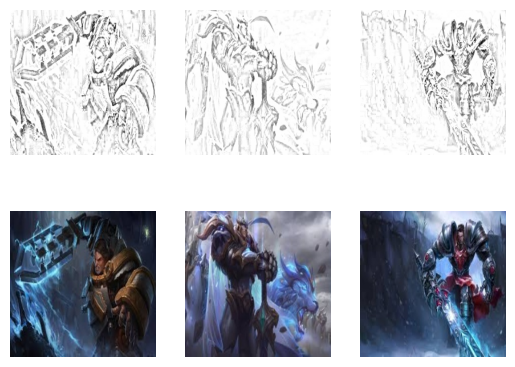

In [30]:
# show images
n_samples = 3
# plot splash arts
for i in range(n_samples):
 pyplot.subplot(2, n_samples, 1 + i)
 pyplot.axis('off')
 pyplot.imshow(src_test_images[i].astype('uint8'))
# plot sketches
for i in range(n_samples):
 pyplot.subplot(2, n_samples, 1 + n_samples + i)
 pyplot.axis('off')
 pyplot.imshow(tar_test_images[i].astype('uint8'))
pyplot.show()

In [31]:
# rescale images
src_test_images = normalize_imgs(src_test_images)
tar_test_images = normalize_imgs(tar_test_images)

In [33]:
# Load the trained model
if COLAB:
  g_model = load_model('/content/gdrive/MyDrive/splash-drawer-files/model_002340.h5', compile=False)

## Results with already seen sketches

In [49]:
# Generate splash arts already seen sketches
generate_splash_art(g_model, tar_images, src_images, 1, n_samples=3)

1/1 [==============================] - 0s 181ms/step
>Saved: /content/outputs/plot_1.png and generated images


<Figure size 640x480 with 0 Axes>

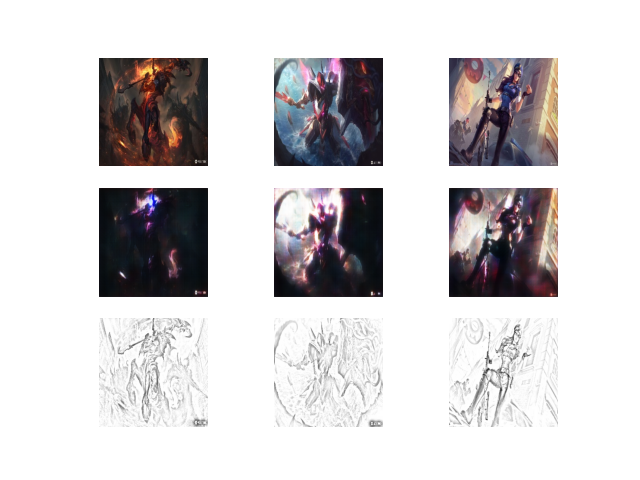

In [50]:
from IPython.display import Image, display
# display images comparison
display(Image(filename='outputs/plot_1.png'))

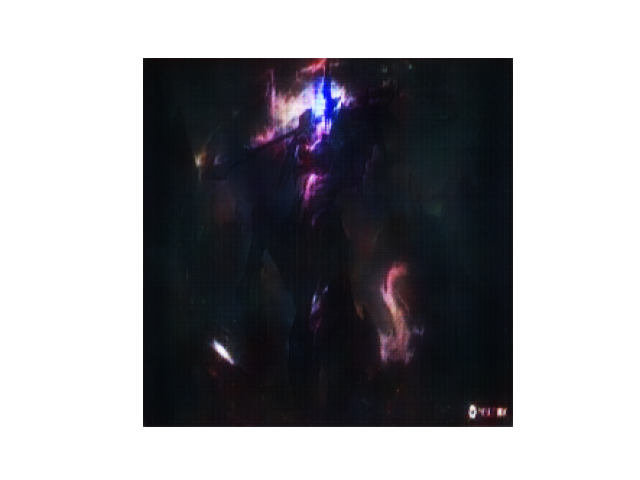

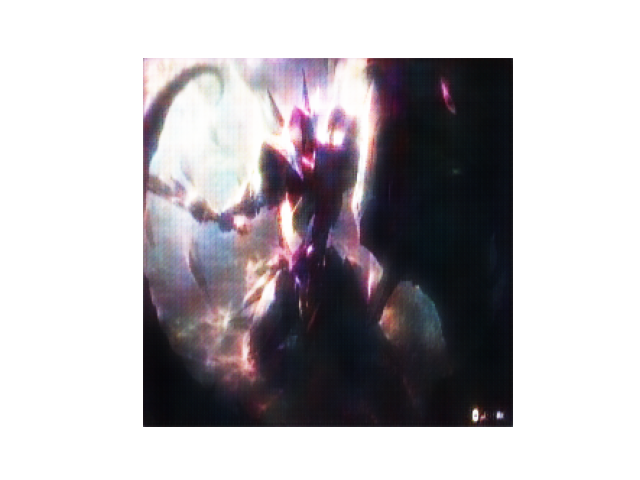

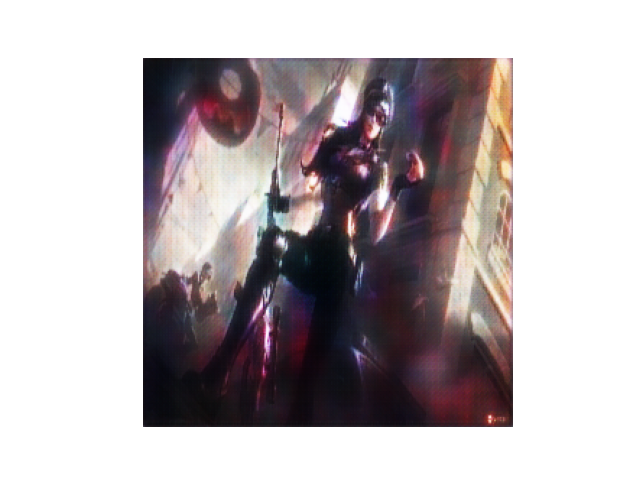

In [52]:
# display generated images
display(Image(filename='outputs/output_1.png'))
display(Image(filename='outputs/output_2.png'))
display(Image(filename='outputs/output_3.png'))

## Results with new sketches

In [39]:
# Generate splash arts from new sketches
generate_splash_art(g_model, tar_test_images, src_test_images, 4, n_samples=3)

1/1 [==============================] - 0s 186ms/step
>Saved: /content/outputs/plot_1.png and generated images


<Figure size 640x480 with 0 Axes>

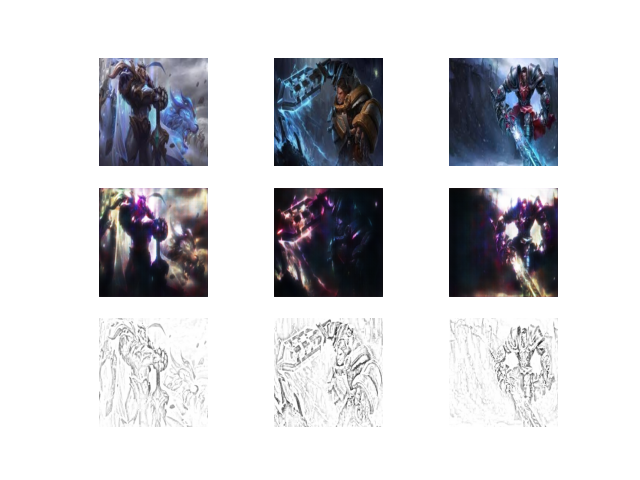

In [44]:
from IPython.display import Image, display
# display images comparison
display(Image(filename='outputs/plot_4.png'))

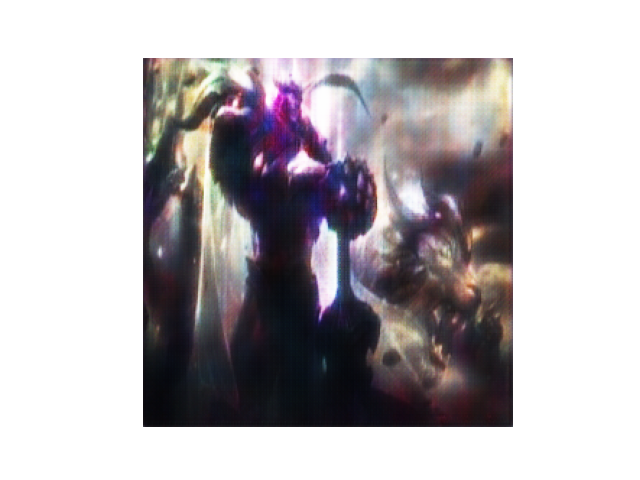

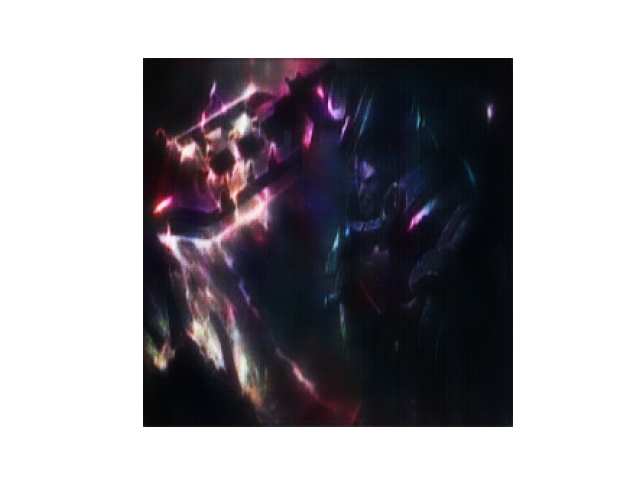

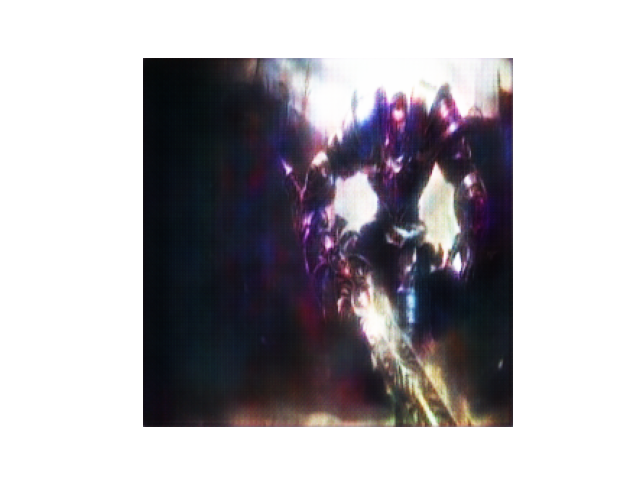

In [42]:
# display generated images
display(Image(filename='outputs/output_4.png'))
display(Image(filename='outputs/output_5.png'))
display(Image(filename='outputs/output_6.png'))

# Final considerations

In this project, i've trained a pix2pix model to generate league of legends splash arts from sketches. The model was trained using the google colab A100 GPU env and Keras API from tensorflow. During the development of the project, I had to deal with memory leaks and delays in training the network, which were solved by changing the version of tensorflow and reducing the resolution of the images from 1500x800 to 256x256. Some design decisions were made in order to prioritize the saving of computational resources, such as the number of epochs trained and the number of input data.

In the end, the network's performance surprised me. I imagined that with few epochs and little data the adversarial model would not generate anything interesting (in the original paper, the authors recommend training for 200 epochs), but after training, the network was able to identify interesting patterns such as textures of characters and buildings, in addition to having autonomy in generating the background of the images, which is not very well defined in the sketches. To improve the network's performance, it is necessary to use more images: with the few tests performed, the model showed a bias in choosing the coloring of the images, which can be improved by showing more training data. Great job done, it was a lot of fun and I was able to learn a lot about conditional GANs.

To see the project details, the process of scrapping the splash art images, resizing and sketches generation, check out the [GitHub project page](https://github.com/JoaoP-Silva/splash-drawer).